In [1]:
# Import TensorFlow library for building and training deep learning models.
import tensorflow as tf
# Import specific modules from TensorFlow's Keras API.
from tensorflow.keras import models, layers
# Import Matplotlib library for data visualization.
import matplotlib.pyplot as plt


In [2]:
# Constants for the Fruit Classification CNN Model
IMAGE_SIZE = 100     # The target size for resizing input images to the CNN model.
BATCH_SIZE = 32      # The number of images processed in each batch during model training.
CHANNELS = 3         # The number of color channels in the input images (e.g., 3 for RGB images).


In [3]:
# Create a dataset from the directory containing fruit images for training.

# Directory path where the fruit images are located.
# Replace ".../MLOPs/fruits-360_dataset/fruits-360/Training" with the actual path to the training image directory.
# The directory should have subdirectories for each class of fruits, with images belonging to each class stored in their respective subdirectories.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    ".../MLOPs/fruits-360_dataset/fruits-360/Training",
    # Shuffle the dataset to improve randomness during training.
    shuffle=True,
    # Resize all images to a common size (IMAGE_SIZE, IMAGE_SIZE) for consistency during training.
    # Replace IMAGE_SIZE with the desired image size (e.g., 224 for 224x224 pixels).
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    # Batch size for each iteration during training.
    # Replace BATCH_SIZE with the desired batch size (e.g., 32, 64, etc.).
    batch_size=BATCH_SIZE
)

Found 67692 files belonging to 131 classes.


In [4]:
class_names = dataset.class_names
class_names[:5]

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3']

In [5]:
len(dataset)

2116

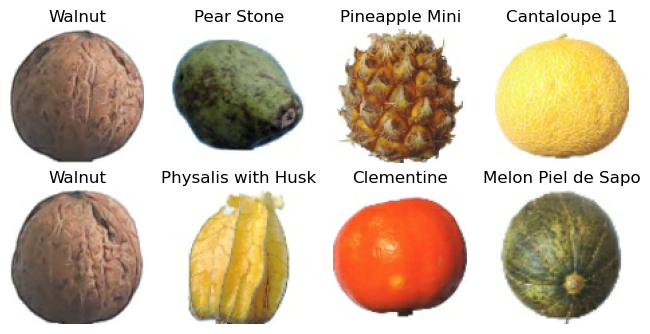

In [6]:
# Display a 4x4 grid of images with labels
import matplotlib.pyplot as plt

# Set the figure size to 8x8 inches
plt.figure(figsize=(8, 8))

# Iterate through the dataset and take the first batch (batch size of 1)
for image_batch, label_batch in dataset.take(1):
    # Loop through the first 8 images in the batch
    for i in range(8):
        # Create a subplot for each image
        ax = plt.subplot(4, 4, i + 1)
        # Convert the image tensor to a NumPy array and cast it to uint8
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        # Set the title of the subplot to the corresponding label from the batch
        plt.title(class_names[label_batch[i]])
        # Turn off the axis ticks for a cleaner display
        plt.axis("off")

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    # Calculate the total size of the dataset
    ds_size = len(ds)

    # Shuffle the dataset if shuffle is True
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    # Calculate the sizes of the training, validation, and test sets based on the given splits
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    # Divide the dataset into three parts: training, validation, and test sets
    # Take the first 'train_size' elements for the training set
    train_ds = ds.take(train_size)
    # Skip the training set and take the next 'val_size' elements for the validation set
    val_ds = ds.skip(train_size).take(val_size)
    # Skip both the training and validation sets and take the next 'val_size' elements for the test set
    test_ds = ds.skip(train_size).take(val_size)
    # Return the three datasets: training, validation, and test sets
    return train_ds, val_ds, test_ds


In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

1692

In [21]:
len(val_ds)

211

In [22]:
len(test_ds)

211

In [23]:
# Caching and shuffling the training dataset to improve data loading performance.
train_ds = train_ds.cache().shuffle(1000)
# Prefetching the training dataset to overlap data preprocessing and model execution.
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
# Caching and shuffling the validation dataset to improve data loading performance.
val_ds = val_ds.cache().shuffle(1000)
# Prefetching the validation dataset to overlap data preprocessing and model execution.
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
# Caching and shuffling the test dataset to improve data loading performance.
test_ds = test_ds.cache().shuffle(1000)
# Prefetching the test dataset to overlap data preprocessing and model execution.
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [25]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [26]:
# Define the input shape of the images (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# Number of classes (output neurons) for the classification task
n_classes = 131

# Create a Sequential model, which is a linear stack of layers
Model = models.Sequential([
    # Preprocessing: Resize and rescale the input images
    resize_and_rescale,
    # Data augmentation: Apply random transformations to the images for increased training data diversity
    data_augmentation,

    # Convolutional layer with 32 filters, each with a 3x3 kernel, using ReLU activation function
    # Input shape is set to INPUT_SHAPE for the first layer
    layers.Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE),
    # MaxPooling layer with 2x2 pooling windows to downsample the feature maps
    layers.MaxPooling2D((2,2)),

    # Convolutional layer with 64 filters and 3x3 kernel, using ReLU activation function
    layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling layer with 2x2 pooling windows
    layers.MaxPooling2D((2,2)),

    # Convolutional layer with 64 filters and 3x3 kernel, using ReLU activation function
    layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling layer with 2x2 pooling windows
    layers.MaxPooling2D((2,2)),

    # Convolutional layer with 64 filters and 3x3 kernel, using ReLU activation function
    layers.Conv2D(64, (3,3), activation='relu'),
    # MaxPooling layer with 2x2 pooling windows
    layers.MaxPooling2D((2,2)),

    # Flatten the output of the previous layers to create a 1D vector
    layers.Flatten(),
    # Fully connected Dense layer with 64 neurons and ReLU activation function
    layers.Dense(64, activation='relu'),
    # Fully connected Dense output layer with n_classes neurons and softmax activation function
    layers.Dense(n_classes, activation='softmax')
])

# Build the model, specifying the input shape
# Note: This is not necessary if the model is trained, as the input shape is inferred from the first layer.
Model.build(input_shape=INPUT_SHAPE)


In [27]:
Model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 100, 100, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 100, 100, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (32, 98, 98, 32)          896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 49, 49, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (32, 47, 47, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 23, 23, 64)          0         
 g2D)                                                 

In [28]:
Model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
EPOCHS = 50

history = Model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/5
1692/1692 [==============================] - ETA: 0s - loss: 1.2495 - accuracy: 0.6453

In [ ]:
scores = Model.evaluate(test_ds)

In [ ]:
history.history.keys()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

In [ ]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.shwo()

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print('first image to predict')
    plt.imshow(first_image)
    print("actual label:" class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predict label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(batch_prediction[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    
    return predicted_class, confidence
    

In [ ]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class}, \n Predicted: {predicted_class}")
        plt.axis('off')